In [1]:
# import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

import warnings

warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [2]:
# load data


ratings_df = pd.read_csv(
    "ml-100k/u.data",
    sep="\t",
    names=["user_id", "movie_id", "rating", "timestamp"],
    header=None,
)

items_df = pd.read_csv(
    "ml-100k/u.item",
    sep="|",
    names=[
        "movie_id",
        "movie_title",
        "release_date",
        "video_release_date",
        "imdb_url",
        "unknown",
        "action",
        "adventure",
        "animation",
        "childrens",
        "comedy",
        "crime",
        "documentary",
        "drama",
        "fantasy",
        "film_noir",
        "horror",
        "musical",
        "mystery",
        "romance",
        "sci_fi",
        "thriller",
        "war",
        "western",
    ],
    header=None,
    encoding="latin-1",
)

users_df = pd.read_csv(
    "ml-100k/u.user",
    sep="|",
    names=["user_id", "age", "gender", "occupation", "zip_code"],
    header=None,
    encoding="latin-1",
)

### Ratings Data

In [3]:
ratings_df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [5]:
# missing value check
ratings_df.isna().apply(pd.value_counts)

,user_id,movie_id,rating,timestamp
False,100000,100000,100000,100000


## Movies / Items Data

In [6]:
items_df.head()

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   imdb_url            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   action              1682 non-null   int64  
 7   adventure           1682 non-null   int64  
 8   animation           1682 non-null   int64  
 9   childrens           1682 non-null   int64  
 10  comedy              1682 non-null   int64  
 11  crime               1682 non-null   int64  
 12  documentary         1682 non-null   int64  
 13  drama               1682 non-null   int64  
 14  fantasy             1682 non-null   int64  
 15  film_noir           1682 non-null   int64  
 16  horror

In [8]:
# drop unnecessary columns
items_df.drop(columns=["video_release_date", "imdb_url"], inplace=True)

In [9]:
# look at movies with unknown genre
items_df[items_df["unknown"] == 1]

,movie_id,movie_title,release_date,unknown,action,adventure,animation,childrens,comedy,crime,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
266,267,unknown,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1372,1373,Good Morning (1971),4-Feb-1971,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# let's see if there is information about the movie_id 1373
ratings_df[ratings_df.movie_id == 1373]

,user_id,movie_id,rating,timestamp
8567,181,1373,1,878962052


In [11]:
# Since the unknown column doesnt have a lot of info and the only movie associated with it was rated only once
items_df.drop(items_df[items_df["unknown"] == 1].index, axis=0, inplace=True)
items_df.drop(columns="unknown", inplace=True)

In [12]:
# missing value check
items_df.isna().apply(pd.value_counts)

,movie_id,movie_title,release_date,action,adventure,animation,childrens,comedy,crime,documentary,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
False,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,...,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680


### Users Data

In [13]:
users_df.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [14]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


In [15]:
# missing value check
users_df.isna().apply(pd.value_counts)

,user_id,age,gender,occupation,zip_code
False,943,943,943,943,943


### EDA Plots

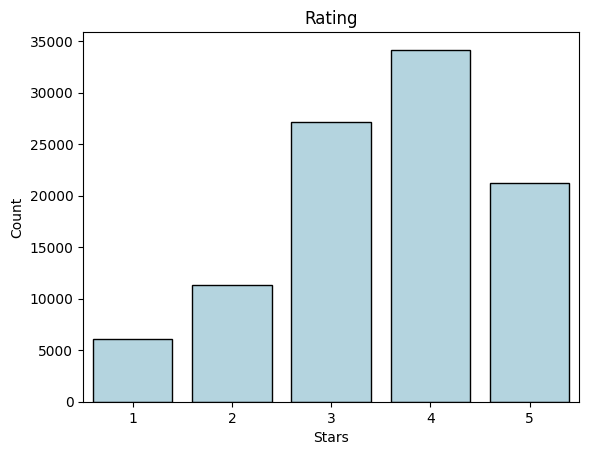

In [16]:
# Bar chart to view distribution of ratings accross all movies
x = ratings_df.rating.value_counts().index
y = ratings_df.rating.value_counts().values / 1000

sns.countplot(x="rating", data=ratings_df, color="lightblue", edgecolor="black")

plt.xlabel("Stars")
plt.ylabel("Count")
plt.title("Rating")

plt.show()

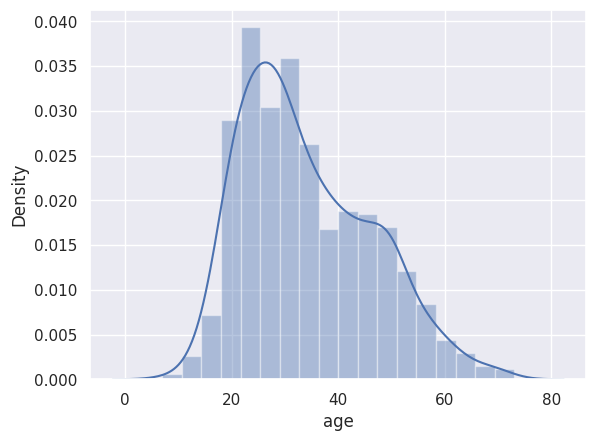

In [17]:
# Distribution of age
sns.set()
sns.distplot(users_df.age)
plt.show()

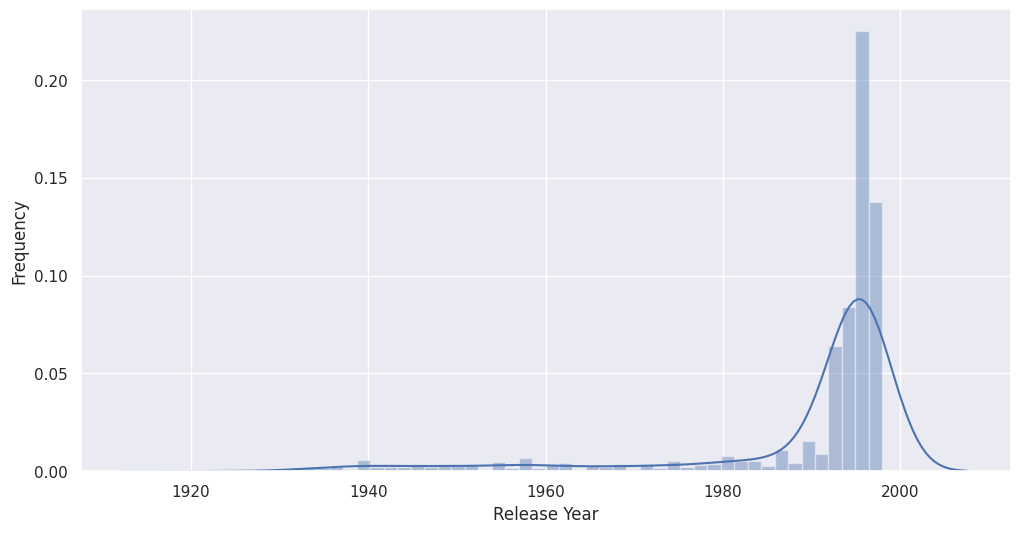

In [20]:
# Distribution of movies w.r.t release year
items_df["release_year"] = pd.to_numeric(
    items_df["release_date"].str.split("-", expand=True)[2], errors="coerce"
)
items_df["release_year"] = items_df["release_year"].dropna().astype(int)

plt.figure(figsize=(12, 6))
sns.distplot(items_df["release_year"])
plt.xlabel("Release Year")
plt.ylabel("Frequency")
plt.show()

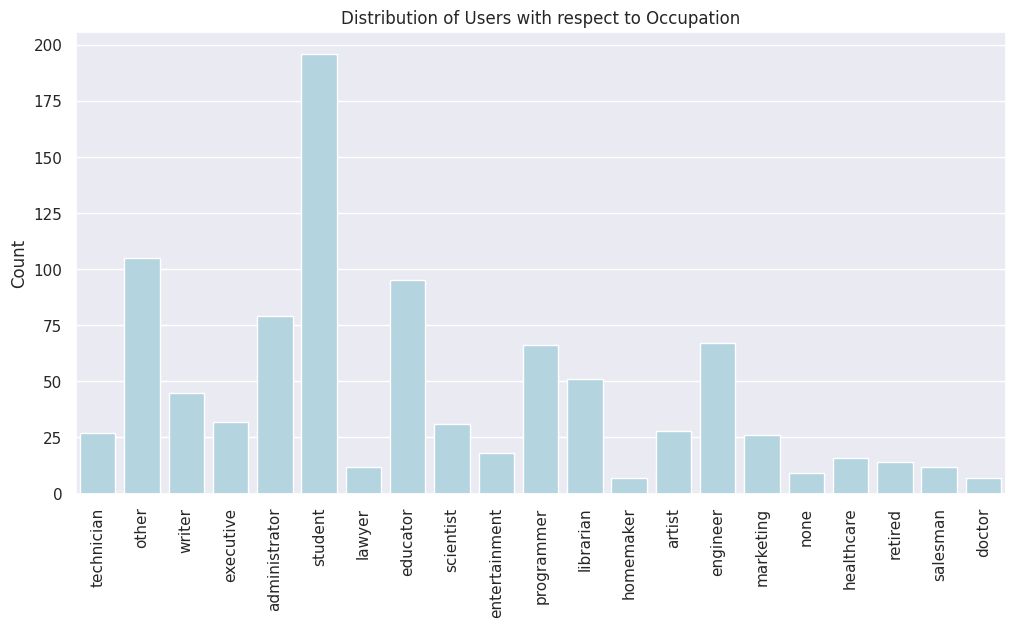

In [23]:
# Distribution of users w.r.t population

plt.figure(figsize=(12, 6))

occupation_counts = users_df["occupation"].value_counts().sort_index()

# Plot the countplot
sns.countplot(x="occupation", data=users_df, color="lightblue")

plt.xticks(rotation=90)

plt.xlabel("")
plt.ylabel("Count")
plt.title("Distribution of Users with respect to Occupation")

plt.show()

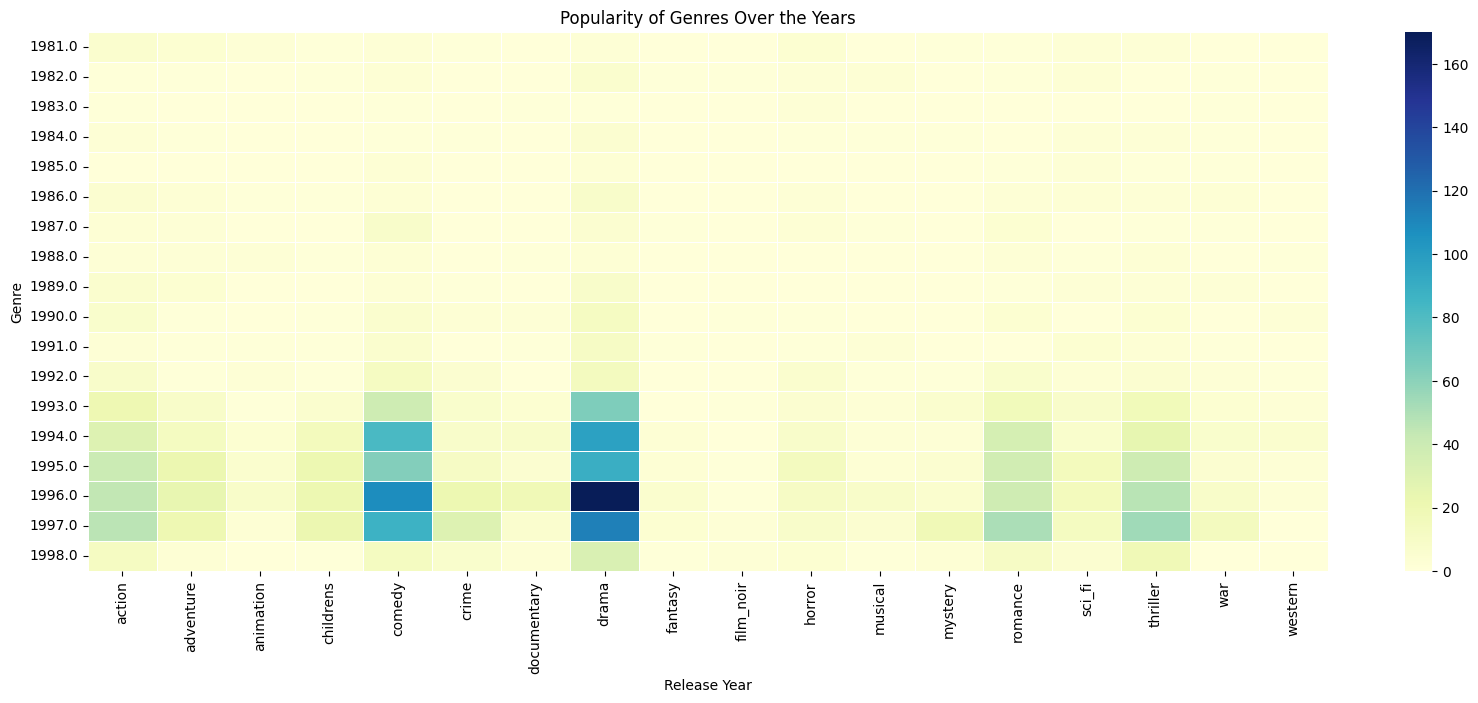

In [8]:
# Visualize how popularity of genres has changed over the years

genre_cols = [
    "action",
    "adventure",
    "animation",
    "childrens",
    "comedy",
    "crime",
    "documentary",
    "drama",
    "fantasy",
    "film_noir",
    "horror",
    "musical",
    "mystery",
    "romance",
    "sci_fi",
    "thriller",
    "war",
    "western",
]

items_df["release_date"] = pd.to_datetime(items_df["release_date"])

items_df["release_year"] = items_df["release_date"].dt.year

items_df = items_df[items_df["release_year"] > 1980]

for genre in genre_cols:
    items_df[genre] = items_df[genre].astype(int)

genre_by_year = items_df.groupby("release_year")[genre_cols].sum()

# Creating a heatmap
plt.figure(figsize=(20, 7))
sns.heatmap(genre_by_year, cmap="YlGnBu", linewidths=0.5, annot=False, fmt=".0f")

plt.xlabel("Release Year")
plt.ylabel("Genre")
plt.title("Popularity of Genres Over the Years")

plt.show()

In [22]:
# Top 25 movies

items = ratings_df.groupby("movie_id").count()
items = items[ratings_df.groupby("movie_id").count().user_id > 100].index
items = ratings_df.loc[ratings_df.movie_id.isin(items)]
items = items.groupby("movie_id").mean()
items = items.sort_values("rating", ascending=False)

order = items.index

rating_list = items.rating[0:25]

items = items_df.loc[items_df["movie_id"].isin(order)]

top_25_movies = items.set_index("movie_id").loc[order]
top_25_movies = top_25_movies.iloc[0:25, 0]
top_25_movies = top_25_movies.reset_index()
top_25_movies["avg_rating"] = rating_list.values

top_25_movies

,movie_id,movie_title,avg_rating
0,408,"Close Shave, A (1995)",4.491071
1,318,Schindler's List (1993),4.466443
2,169,"Wrong Trousers, The (1993)",4.466102
3,483,Casablanca (1942),4.456790
4,64,"Shawshank Redemption, The (1994)",4.445230
5,603,Rear Window (1954),4.387560
6,12,"Usual Suspects, The (1995)",4.385768
7,50,Star Wars (1977),4.358491
8,178,12 Angry Men (1957),4.344000
9,134,Citizen Kane (1941),4.292929


In [23]:
# rank genres by gender

result = pd.merge(ratings_df, users_df, how="inner", on="user_id")
result = pd.merge(result, items_df, how="inner", on="movie_id")

subset = result[["gender"] + genre_cols]

genre_totals_gender = subset.groupby("gender").sum()

ranked_genres_gender = pd.DataFrame()

for gender in genre_totals_gender.index:
    ranked_genres_gender[gender] = (
        genre_totals_gender.loc[gender].sort_values(ascending=False).index
    )

print(ranked_genres_gender)

              F            M
0         drama        drama
1        comedy       comedy
2       romance       action
3        action     thriller
4      thriller      romance
5     adventure    adventure
6        sci_fi       sci_fi
7     childrens          war
8           war        crime
9         crime    childrens
10      musical       horror
11      mystery      mystery
12       horror      musical
13    animation    animation
14    film_noir      western
15      western    film_noir
16      fantasy      fantasy
17  documentary  documentary


## Application of MF (Collaborative Filtering using Surprise)

In [39]:
# Load the movielens-100k dataset
data = Dataset.load_builtin("ml-100k")

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9264  0.9327  0.9342  0.9302  0.9241  0.9233  0.9376  0.9326  0.9338  0.9229  0.9298  0.0050  
MAE (testset)     0.7294  0.7335  0.7355  0.7309  0.7301  0.7280  0.7370  0.7372  0.7356  0.7262  0.7323  0.0037  
Fit time          5.10    5.13    5.05    5.01    5.12    5.05    5.03    5.04    5.00    5.11    5.06    0.04    
Test time         0.07    0.10    0.06    0.06    0.06    0.06    0.06    0.07    0.06    0.06    0.07    0.01    


{'test_rmse': array([0.92635854, 0.93265092, 0.93418158, 0.93018205, 0.92412731,
        0.92329648, 0.9375529 , 0.93264226, 0.93384779, 0.92288111]),
 'test_mae': array([0.72943636, 0.73354904, 0.73548478, 0.73086936, 0.73007841,
        0.72804553, 0.73698405, 0.73719063, 0.73556953, 0.72624064]),
 'fit_time': (5.095418214797974,
  5.1325860023498535,
  5.049536228179932,
  5.0136377811431885,
  5.11835789680481,
  5.051538944244385,
  5.029559373855591,
  5.038602352142334,
  5.000664949417114,
  5.107391595840454),
 'test_time': (0.06582379341125488,
  0.10269665718078613,
  0.05983543395996094,
  0.05881023406982422,
  0.06183505058288574,
  0.05884194374084473,
  0.058875083923339844,
  0.06579113006591797,
  0.06280684471130371,
  0.058837890625)}